This Notebook is for removing outliers from our dataset. Currently we remove businesses that have extremely high consumer and merchant frauds .

In [28]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import col, to_date, when, concat, lit
from pyspark.sql.types import TimestampType
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

spark = SparkSession.builder \
    .appName("green preprocessing") \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .config("spark.sql.parquet.cacheMetadata", "true") \
    .config("spark.sql.session.timeZone", "Etc/UTC") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

In [46]:
path1 = "../../../data/insights/joined.parquet"
df = spark.read.parquet(path1)
df.show(5)
df.printSchema()
print("length:",df.count())
df_pandas = df.toPandas()



+------------+--------------------+-------------+---------+----------------------------------+-------------------+----------------------------------+--------------------------+----------------+---------------------+-------------------+--------------------------------+---------------------------+------------------+---------------------------------+--------------------+--------------------+
|merchant_abn|                name|revenue_level|take_rate|average_merchant_fraud_probability|number_of_consumers|average_consumer_fraud_probability|number_of_repeat_consumers|number_of_orders|average_cost_of_order|number_of_postcodes|avg_total_weekly_personal_income|avg_total_weekly_fam_income|    avg_median_age|avg_num_of_consumers_per_postcode|merchant_description|             segment|
+------------+--------------------+-------------+---------+----------------------------------+-------------------+----------------------------------+--------------------------+----------------+---------------------+-

garden_and_furnishings
5.26


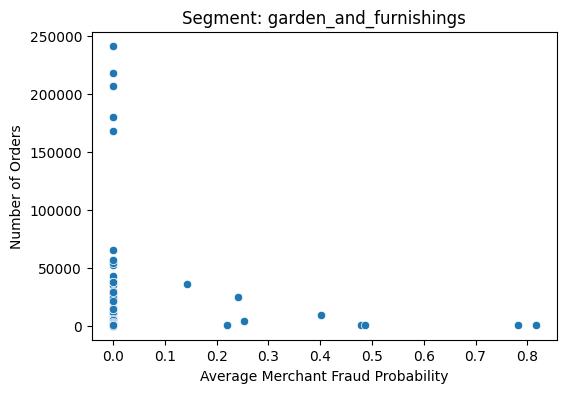

tech_and_electronics
6.0


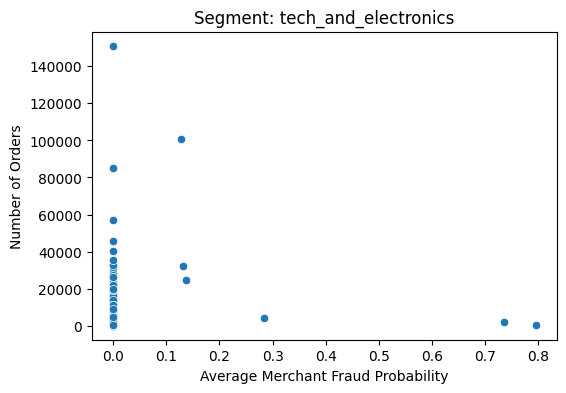

antiques_and_jewellery
1.0


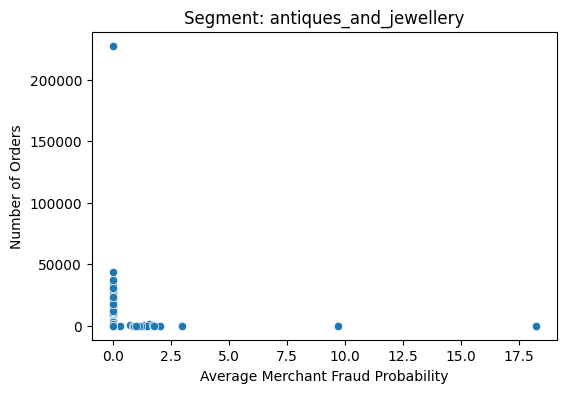

retail_and_novelty
10.63


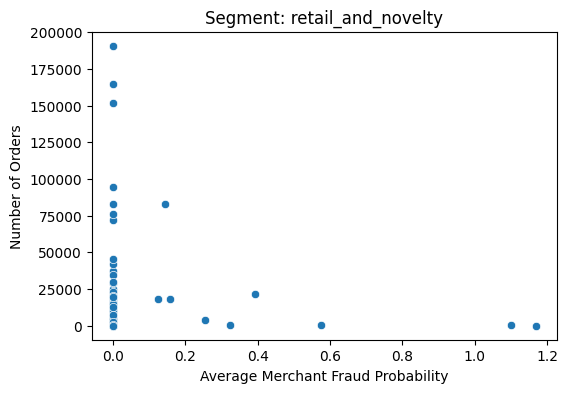

specialized_services
5.0


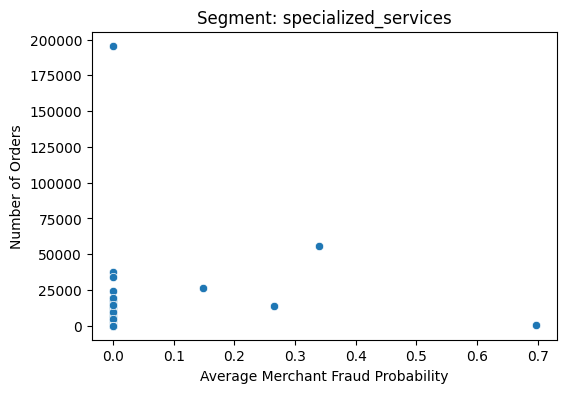

,merchant_abn,name,revenue_level,take_rate,average_merchant_fraud_probability,number_of_consumers,average_consumer_fraud_probability,number_of_repeat_consumers,number_of_orders,average_cost_of_order,number_of_postcodes,avg_total_weekly_personal_income,avg_total_weekly_fam_income,avg_median_age,avg_num_of_consumers_per_postcode,merchant_description,segment
0,17228439250,Erat Foundation,a,6.61,0.0000,5,3.603860,NaN,5,3254.492000,5,878.500000,2099.300000,40.200000,1.0,"equipment, tool, furniture, and appliance rent...",garden_and_furnishings
1,24102148742,Amet Metus Aliquam Industries,b,4.24,0.0000,5,2.075080,NaN,5,2728.244000,5,737.100000,1924.300000,44.800000,1.0,"equipment, tool, furniture, and appliance rent...",garden_and_furnishings
2,34775154874,Tellus Ltd,c,2.46,0.0000,4,4.386975,NaN,4,2571.875000,4,762.750000,1916.750000,43.000000,1.0,"furniture, home furnishings and equipment shop...",garden_and_furnishings
3,38447958250,Lobortis Quam Incorporated,b,4.39,0.0000,3,0.000000,NaN,3,3181.133333,3,798.166667,2108.666667,39.000000,1.0,"furniture, home furnishings and equipment shop...",garden_and_furnishings
4,38523766800,Elit Elit Fermentum Foundation,a,5.94,0.0000,5,0.000000,NaN,5,1313.750000,5,792.000000,2060.700000,41.100000,1.0,"furniture, home furnishings and equipment shop...",garden_and_furnishings
5,50940521426,Vel Est Tempor Ltd,c,2.69,0.0000,5,3.993920,NaN,5,2359.058000,5,958.900000,2457.700000,43.000000,1.0,"equipment, tool, furniture, and appliance rent...",garden_and_furnishings
6,69853421807,Fusce Mollis Duis Industries,a,6.28,0.0000,3,0.000000,NaN,3,2892.423333,3,703.666667,1713.333333,48.333333,1.0,"equipment, tool, furniture, and appliance rent...",garden_and_furnishings
7,85273542431,Vel Est Incorporated,b,3.50,0.0000,5,4.709960,NaN,5,4385.002000,5,888.800000,2346.300000,38.800000,1.0,"equipment, tool, furniture, and appliance rent...",garden_and_furnishings
8,96190048310,Penatibus Et Inc.,c,2.09,0.0000,4,2.927625,NaN,4,4931.800000,4,749.125000,1935.875000,46.750000,1.0,"equipment, tool, furniture, and appliance rent...",garden_and_furnishings
9,12182018430,Integer In Ltd,b,3.27,0.0000,6,0.000000,NaN,6,2346.343333,6,607.000000,1492.333333,47.666667,1.0,telecom,tech_and_electronics


length:  54


In [49]:
import pandas as pd
import seaborn as sns
# Initialize an empty list to hold the outliers
outliers_list = []

# Define a function to calculate upper bound outliers
def get_outliers(df, column_name):
    lower_bound = df[column_name].quantile(0.01)
    print(lower_bound)
    return df[df[column_name] <= lower_bound]

for segment in df_pandas['segment'].unique():
    # Filter the dataframe for each segment
    segment_df = df_pandas[df_pandas['segment'] == segment]
    print(segment)
    # Get upper bound outliers for average_consumer_fraud_probability
    consumer_fraud_outliers = get_outliers(segment_df, 'number_of_orders')
    
    # Add them to the list
    outliers_list.extend(consumer_fraud_outliers.to_dict(orient='records'))
    
    # Plotting the scatter plot
    plt.figure(figsize=(6,4))
    sns.scatterplot(x='average_merchant_fraud_probability', y='number_of_orders', data=segment_df)
    plt.title(f'Segment: {segment}')
    plt.xlabel('Average Merchant Fraud Probability')
    plt.ylabel('Number of Orders')
    plt.show()

# Create a DataFrame from the outliers_list
outliers_df = pd.DataFrame(outliers_list)
display(outliers_df)
print("length: ",len(outliers_df))

In [47]:
df_pandas_cleaned = df_pandas.loc[df_pandas['number_of_orders'] > 3]


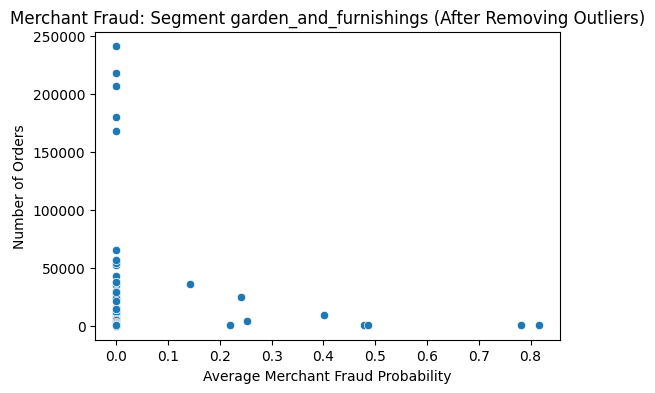

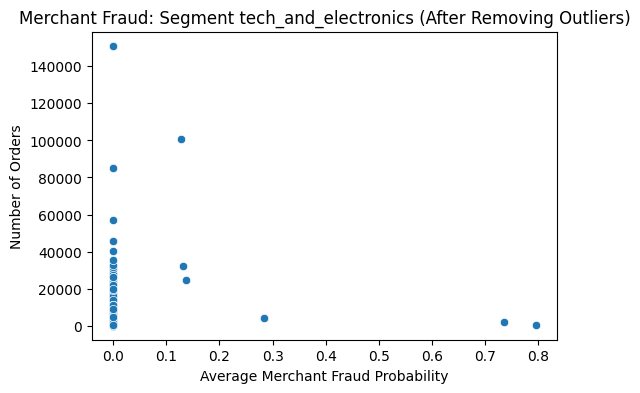

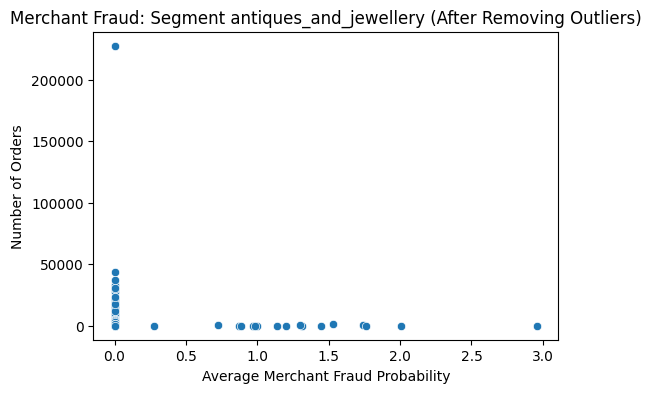

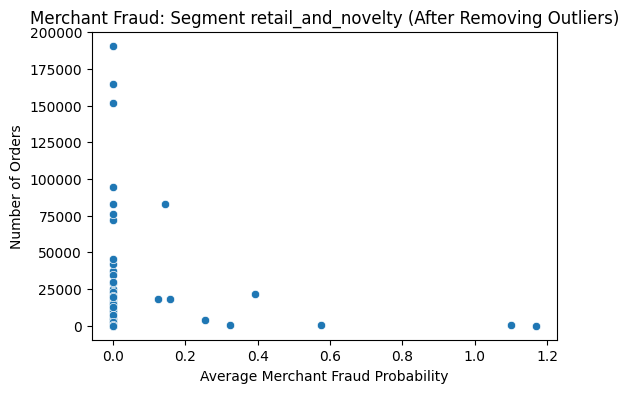

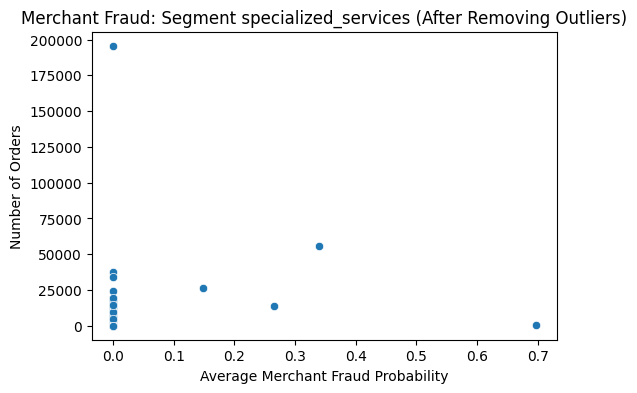

In [48]:
# Loop through each segment and plot
for segment in df_pandas_cleaned['segment'].unique():
    segment_df = df_pandas_cleaned[df_pandas_cleaned['segment'] == segment]

    # Filter the cleaned dataframe for each segment    
    # Plotting the scatter plot for merchant fraud
    plt.figure(figsize=(6,4))
    sns.scatterplot(x='average_merchant_fraud_probability', y='number_of_orders', data=segment_df)
    plt.title(f'Merchant Fraud: Segment {segment} (After Removing Outliers)')
    plt.xlabel('Average Merchant Fraud Probability')
    plt.ylabel('Number of Orders')
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

segments = df.select("segment").distinct().rdd.flatMap(lambda x: x).collect()
total_outliers = []
for segment in segments:
    # Filter data for the current segment
    segment_df = df.filter(df.segment == segment).toPandas()  # Convert to pandas for ease of plotting

    # Calculate 1% and 99% percentiles for both variables
    upper_merchant = segment_df['average_merchant_fraud_probability'].quantile(0.95)
    upper_consumer = segment_df['average_consumer_fraud_probability'].quantile(0.95)

    # Filter outliers
    outliers = segment_df[
        (segment_df['average_merchant_fraud_probability'] > upper_merchant) &
        (segment_df['average_consumer_fraud_probability'] > upper_consumer)
    ]
    total_outliers.extend(outliers.to_dict('records'))
    # Plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=outliers, x='average_merchant_fraud_probability', y='average_consumer_fraud_probability', hue='segment', palette='deep')
    plt.title(f'Outliers in Segment: {segment}')
    plt.show()

total_outliers = [row['merchant_abn'] for row in total_outliers]
df = df.filter(~df.merchant_abn.isin(total_outliers))


In [ ]:
outliers_list = []  # Initialize an empty list to store the outliers.

for segment in segments:
    # Filter data for the current segment
    segment_df = df.filter(df.segment == segment).toPandas()  # Convert to pandas for ease of plotting

    # Calculate 95% percentiles for both variables
    upper_merchant = segment_df['average_merchant_fraud_probability'].quantile(0.95)
    upper_consumer = segment_df['average_consumer_fraud_probability'].quantile(0.95)

    # Filter outliers
    outliers = segment_df[
        (segment_df['average_merchant_fraud_probability'] > upper_merchant) &
        (segment_df['average_consumer_fraud_probability'] > upper_consumer)
    ]

    # Append the outliers to the list
    outliers_list.extend(outliers.to_dict('records'))

    # Plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=outliers, x='average_merchant_fraud_probability', y='average_consumer_fraud_probability', hue='segment', palette='deep')
    plt.title(f'Outliers in Segment: {segment}')
    plt.show()
    print(outliers)

# After the loop, you can create a DataFrame from the outliers_list and remove those rows from the original DataFrame if needed.
outliers_df = pd.DataFrame(outliers_list)
